**Assignment01 Computer Vision Spring 2021**

*Aoun Hussain - ah03974*

*Training Neural Networks for Image Classification*


#Task 1 a

#Load Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
import cv2

In [3]:
ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)

In [4]:
print(ds)
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

<_OptionsDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
Num classes: 2
Class names: ['parasitized', 'uninfected']


#Visualize Data

In [5]:
print(info) #information for the dataset, info is the class
print(type(info)) #a class

tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
      and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger, 
      Stefan and Thoma, George R}

In [6]:
print(info.features['label']) #shows the class for class label

ClassLabel(shape=(), dtype=tf.int64, num_classes=2)


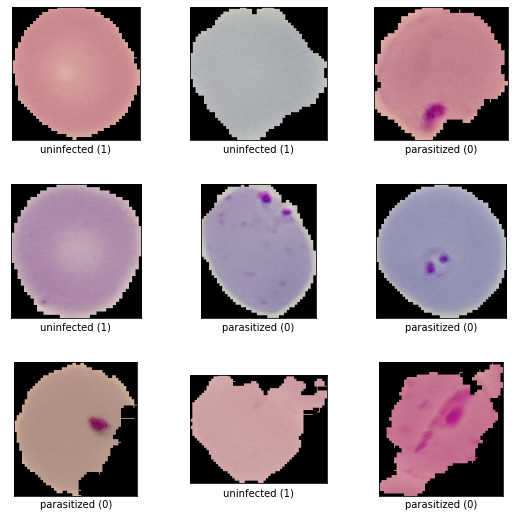

In [7]:
visualized = tfds.visualization.show_examples(ds, info)

**We can see that images with spots are parasitized, where as uninfected images have no spots on them.**

#Task 1 b

**Binary Classification:**

*Binary classification is the simplest kind of machine learning problem. The goal of binary classification is to categorise data points into one of two buckets: 0 or 1, true or false, to survive or not to survive, blue or no blue eyes, etc.*

Following algorithms can be used for binary classification:

*   Logistic Regression.
*   k-Nearest Neighbors.
*   Naive Bayes.
*   Support Vector Machine.
*   Decision Trees.

We are using binary classification for this task because there are two classes in the malaria dataset and we will predict one of these classes through our model, hence we will use a binary classification model.







#Task 1 c - Preprocess the data (padding and gray scaling)

In [8]:
train_images = []  #loading dataset in numpy arrays
train_labels = []

for sample in ds: 
    train_images.append(sample['image'].numpy())
    train_labels.append(sample['label'].numpy())

train_images = np.array(train_images)  #all the data is loaded in the train variable for now
train_labels = np.array(train_labels)
print(len(train_images))

27558


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [9]:
train_images = train_images[:20000]  #all the data is loaded in the train variable for now
train_labels = train_labels[:20000]  #image samples are reduced as RAM was exhausted during flattening
#so only first 20000 samples are considered from 27558 samples
images_flattened = [x.flatten().astype('float64') for x in train_images] #flattening the images and making it a feauture vector


In [10]:
img_lengths = [] #finding lengths of the flattened image samples

for img in images_flattened:
    img_lengths.append(len(img))

img_lengths = np.array(img_lengths)

uninfected_lengths = img_lengths[train_labels == 1]
parasitized_lengths = img_lengths[train_labels == 0]

In [11]:
scipy.stats.describe(uninfected_lengths)

DescribeResult(nobs=10011, minmax=(12540, 139260), mean=52451.932574168415, variance=167752308.761787, skewness=0.9005420282393334, kurtosis=2.6961699202565077)

In [12]:
scipy.stats.describe(parasitized_lengths)

DescribeResult(nobs=9989, minmax=(6600, 285285), mean=54650.66753428771, variance=261227704.68771338, skewness=2.238331288025102, kurtosis=15.885364683296693)

*We can see that out of 20000 samples, we have 10011 uninfected samples and 9989 infected samples. We can also see that the length of the flattened images are very different from each other*

*Hence, to make the sample images of equal size, we will use padding, this is also a part of preprocessing*

**we are deleting all the previous memory to save RAM**

**we will then flatten and pad the images to make them of equal dimensions**

In [13]:
del ds
del info
del train_images
del train_labels
del images_flattened
del img_lengths

In [14]:
IMAGE_SIZE = [200, 200]

#splitting the dataset into test and train and validation
train_ds, val_ds, test_ds = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True)

In [15]:
train_ds = train_ds.take(5000) #reducing the size of the dataset to save RAM
test_ds = test_ds.take(500)

In [16]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image,label

In [17]:
padded_train_ds = ( #preprocessing
    train_ds
    .cache()
    .map(pad)
) 

padded_val_ds = (
    val_ds
    .cache()
    .map(pad)
)

padded_test_ds = (
    test_ds
    .cache()
    .map(pad)
)

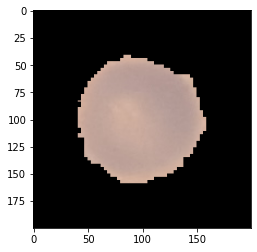

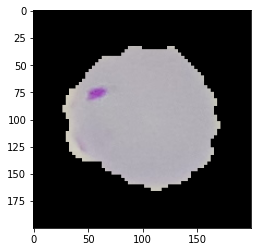

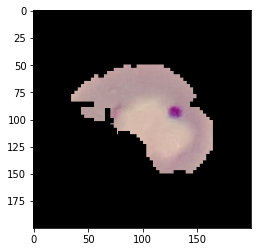

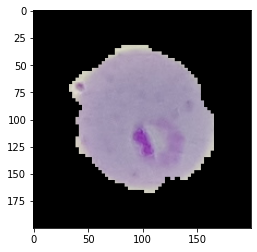

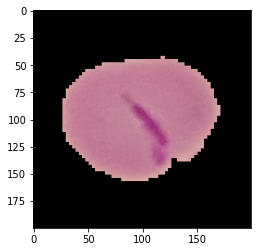

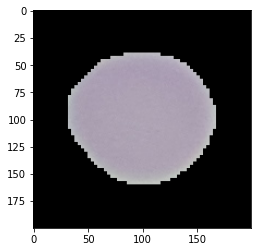

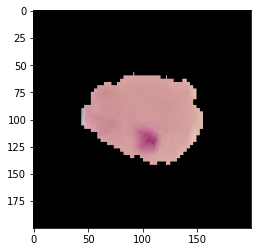

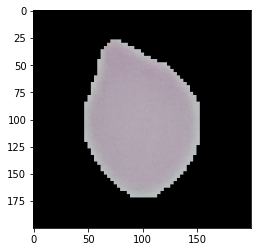

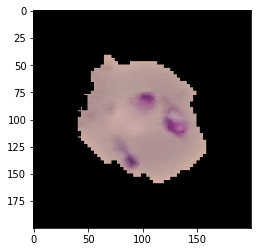

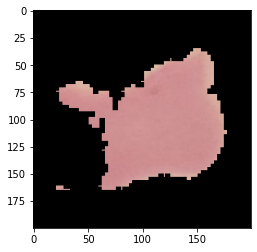

In [18]:
x = padded_test_ds.take(10) #for the sake of visualizing the preprocessed data
for i in x:
  plt.figure()
  plt.imshow(i[0])

**The above results shows the preprocessed images which are of equal dimesions and padded**

Now we will convert these padded images into gray scaled images to reduce the computation complexity

In [40]:
def rgb2gray(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

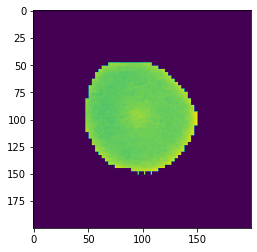

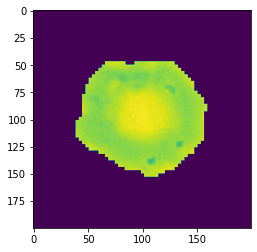

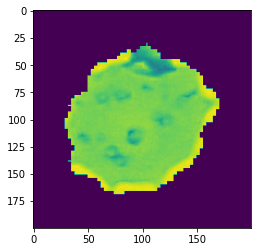

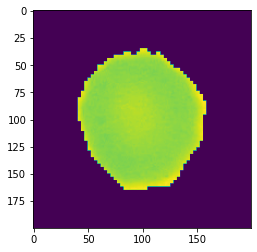

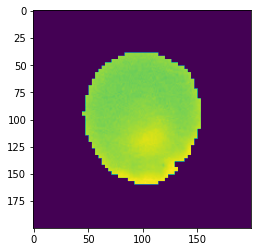

In [34]:
Xgray_training = [rgb2gray(i[0]) for i in tfds.as_numpy(padded_train_ds)]
Xgray_testing  = [rgb2gray(i[0]) for i in tfds.as_numpy(padded_test_ds)]

for i in Xgray_training[:5]:
  plt.figure()
  plt.imshow(i)

**The above images show gray scaled and padded images**

Now flattening the images again to feed to the model

In [35]:
flattened_test_images = []  #only using the test and train data sets
test_labels = []

for image in Xgray_testing:
  flattened_test_images.append(image.flatten().astype('float64'))

for image in tfds.as_numpy(padded_test_ds):
  test_labels.append(image[1])

In [36]:
flattened_train_images = []
train_labels = []

for image in Xgray_training:
  flattened_train_images.append(image.flatten().astype('float64'))

for image in tfds.as_numpy(padded_train_ds):
  train_labels.append(image[1])

#Task 1 d,e - Build and test on Logistic Regression Model

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
reg = LogisticRegression().fit(flattened_train_images, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [39]:
score = reg.score(flattened_test_images, test_labels)
print(score)

0.558


**The model gave an accuracy of 62% when images were not gray scaled and only padded**

**The model is now giving an accuracy of 55.8% when padded and gray scaled images are used**

#Task 2 - Loading the Cifar-10 Dataset

170500096/170498071 [==============================] - 2s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


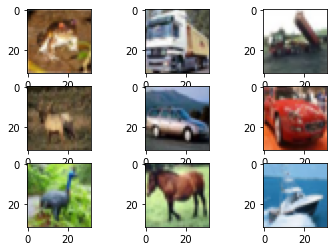

In [ ]:
from matplotlib import pyplot
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

**CIFAR-10 Photo Classification Dataset**

*CIFAR is an acronym that stands for the Canadian Institute For Advanced Research and the CIFAR-10 dataset was developed along with the CIFAR-100 dataset by researchers at the CIFAR institute.*

*The dataset is comprised of 60,000 32×32 pixel color photographs of objects from 10 classes, such as frogs, birds, cats, ships, etc. The class labels and their standard associated integer values are listed below.*

* 0: airplane
*1: automobile
*2: bird
*3: cat
*4: deer
*5: dog
*6: frog
*7: horse
*8: ship
*9: truck

These are very small images, much smaller than a typical photograph, and the  dataset was intended for computer vision research.

Following preprocessing can be done on the dataset:

*   Flatten the image and take it as a feature vector
*   Gray scaling the image
*   Normalize the data for faster training
*   Resize the data by padding
*   Add filters to detect edges such as gaussian filters



#Task 3 - Filt

The Filt Function was made using only Numpy. It works for both RGB and Grayscale images of any sizes. Different matrices are tested on this filter. One is the 5x5 average smoothing filter, an edge detection filter and a sharpening filter.

In [ ]:
def filt(input_, filter_, padding = True, norm = False):
  if len(input_.shape) == 2: #if image is gray
    w, h = input_.shape
    d = 1
  elif len(input_.shape) == 3: #if image is rgb
    w, h, d = input_.shape
  fw, fh = filter_.shape
  if padding: # pad the image with 0s. number of pad rows/cols depends on kernel
    if d == 1: input_m = np.pad(input_, ((fw//2, fw//2), (fw//2, fh//2)), 'constant')
    elif d == 3: input_m = np.pad(input_, ((fw//2, fw//2), (fw//2, fh//2), (0, 0)), 'constant')
    xrange = range(fw//2,w+fw//2)
    yrange = range(fh//2,h+fh//2)
    input_im = np.zeros(input_.shape)
  else:
    input_m = input_
    xrange = range(fw//2,w-fw//2)
    yrange = range(fh//2,h-fh//2)
    if d == 1:
      input_im = np.zeros((w-fw//2,h-fh//2)) #output image
    elif d == 3:
      input_im = np.zeros((w-fw+1,h-fh+1, d)) #output image
  for i in xrange: #perform convolution on the image
    for j in yrange:
      red = 0
      blue = 0
      green = 0
      for a in range(fw):
        for b in range(fh):
            if d == 1:
              red += input_m[(i+a-(fw//2))][(j+b-(fh//2))] * filter_[a][b];
            elif d == 3:
              red += input_m[(i+a-(fw//2))][(j+b-(fh//2))][0] * filter_[a][b];
              blue += input_m[i+a-(fw//2)][j+b-(fh//2)][1] * filter_[a][b];
              green += input_m[i+a-(fw//2)][j+b-(fh//2)][2] * filter_[a][b];
      if d == 1:
        input_im[i-fw//2][j-fh//2] = max(0, min(255, red))  
      elif d == 3:
        input_im[i-fw//2][j-fh//2][0] = max(0, min(255, red))
        input_im[i-fw//2][j-fh//2][1] = max(0, min(255, blue))
        input_im[i-fw//2][j-fh//2][2] = max(0, min(255, green))
  if (norm): #normalize the image and bring it to 0-1 scale
    input_im /= 255
    return input_im.astype('float32') # for 0-1
  else:
    return input_im.astype('uint8')   # for 0-255

In [ ]:
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTj_YfC8v12sOumHGDivch1EJGgCDFlw3dV4RBzNPwBHe4I7QsON3OHBAIVLjwMOAS71Q4&usqp=CAU

image = cv2.imread("images?q=tbn:ANd9GcTj_YfC8v12sOumHGDivch1EJGgCDFlw3dV4RBzNPwBHe4I7QsON3OHBAIVLjwMOAS71Q4")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Sharpening Filter 
Sharpen = np.array([[0, -1, 0.02],
                    [-1, 5, -1],
                    [0, -1, 0]])

# 5x5 averaging Filter - used for blurrring the image
xs = 5
Avg = 1/(xs ** 2) * np.ones((xs,xs))

# Edge Detection Filter
filter2 = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])
f = []
f.append(Avg)
f.append(Sharpen)
f.append(filter2)

p = [[],[],[]]
for i in range(3):
  p[i].append(image)
  p[i].append(filt(image, f[i], padding=True, norm = False))
  p[i].append(filt(image, f[i], padding=False, norm = False))
  p[i].append(filt(image, f[i], padding=True, norm = True))
  p[i].append(filt(image, f[i], padding=False, norm = True))
  p[i].append(cv2.filter2D(image, -1, f[i]))

--2021-04-18 12:13:54--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTj_YfC8v12sOumHGDivch1EJGgCDFlw3dV4RBzNPwBHe4I7QsON3OHBAIVLjwMOAS71Q4
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.142.100, 74.125.142.113, 74.125.142.101, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4587 (4.5K) [image/jpeg]
Saving to: ‘images?q=tbn:ANd9GcTj_YfC8v12sOumHGDivch1EJGgCDFlw3dV4RBzNPwBHe4I7QsON3OHBAIVLjwMOAS71Q4.1’

images?q=tbn:ANd9Gc 100%[===================>]   4.48K  --.-KB/s    in 0s      

2021-04-18 12:13:54 (47.5 MB/s) - ‘images?q=tbn:ANd9GcTj_YfC8v12sOumHGDivch1EJGgCDFlw3dV4RBzNPwBHe4I7QsON3OHBAIVLjwMOAS71Q4.1’ saved [4587/4587]



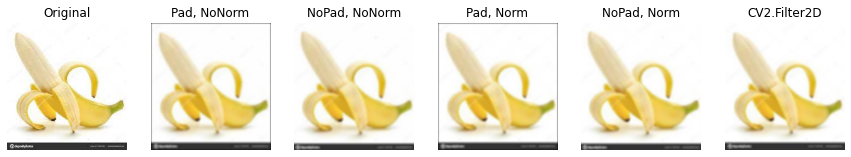

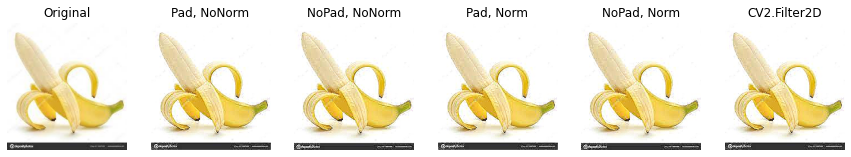

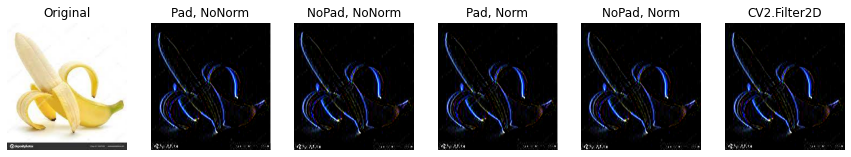

In [ ]:
titles = ["Original", "Pad, NoNorm", "NoPad, NoNorm", "Pad, Norm", "NoPad, Norm", "CV2.Filter2D"]
for j in range(3):
  plt.figure(figsize=(15,15))
  for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(p[j][i])
    plt.axis('off')
    plt.title(titles[i])

The first row is of the filter which blurs the original image

The second row is of sharpening filter

The third row is of edge detection filter

#Task 4 - HOG & Linear SVM (SVM)



In [ ]:
from skimage.feature import hog 
import sklearn
import numpy as np
from keras.datasets import cifar10
import cv2

**Extracting feautures using HOG**

In [ ]:
(xtrain,ytrain),(xtest,ytest) = cifar10.load_data()
print("xtrain: ",xtrain.shape, " ytrain:", ytrain.shape)
print("xtest: ",xtest.shape," ytest: ", ytest.shape)

xtrain = xtrain[:10000] #reducing the dataset as it was taking too much time to train the SVM
ytrain = ytrain[:10000]
xtest = xtest[:1000]
ytest = ytest[:1000]
print("xtrain: ",xtrain.shape, " ytrain:", ytrain.shape)
print("xtest: ",xtest.shape," ytest: ", ytest.shape)

xtrain:  (50000, 32, 32, 3)  ytrain: (50000, 1)
xtest:  (10000, 32, 32, 3)  ytest:  (10000, 1)
xtrain:  (10000, 32, 32, 3)  ytrain: (10000, 1)
xtest:  (1000, 32, 32, 3)  ytest:  (1000, 1)


In [ ]:
def rgb2gray(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

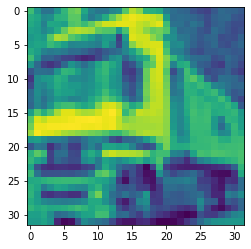

In [ ]:
Xgray_training = [rgb2gray(xtrain[i]) for i in range(len(xtrain))]
Xgray_testing  = [rgb2gray(xtest[i]) for i in range(len(xtest))]

plt.imshow(Xgray_training[1])  #gray scaled the images as accuracy was poor before

**Gray scaling did not work, so not using gray scaled data**

**Increasing the orientations of the gradients during HOG feauture extraction helped to increase the accurcay of the SVM model**

Multichannel is false as gray scale images are being processed

In [ ]:
xtrain_hog = []
xtest_hog = []
for i in range (len(xtrain)):  #extracting feautures from the gray scaled training set
          fd, hog_image = hog(Xgray_training[i], orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
          xtrain_hog.append(fd)
for i in range (len(xtest)):   #extracting feautures from the gray scaled testing set
          fd, hog_image = hog(Xgray_testing[i], orientations=8, pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
          xtest_hog.append(fd)

**Now Implementing Linear SVM or SVM**

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

linear_svc = svm.SVC(kernel='linear')
linear_svc = svm.SVC() 

linear_svc.fit(xtrain_hog,ytrain)   #training


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
Output = linear_svc.predict(xtest_hog) #testing
score = accuracy_score(ytest, Output)
print(score)

0.53


**The HOG-SVM has given an accuracy of 53 percent as shown above**

#Task 5 - Cifar-10 Models

#Task 5-a - Feed Forward Neural Networks

In [1]:
#Imports
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense , Dropout

In [2]:
# Preprocessing and Flattening for ANN
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = (X_train-X_train.mean(axis = 0))/X_train.std(axis = 0)
X_test = (X_test-X_test.mean(axis = 0))/X_test.std(axis = 0)

X_train_new = np.array([i.flatten() for i in X_train])
X_test_new = np.array([i.flatten() for i in X_test])

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#printing shapes
print(X_train_new.shape)
print(X_test_new.shape)

print(y_train.shape)
print(y_test.shape)

170500096/170498071 [==============================] - 7s 0us/step
(50000, 3072)
(10000, 3072)
(50000, 10)
(10000, 10)


In [3]:
X_val_new = X_train_new[49000:50000]
y_val = y_train[49000:50000]

In [4]:
X_train_new = X_train_new[:49000]
y_train = y_train[:49000]

In [5]:
# For plotting the loss and accuracy over epochs
def plotter(history):
  plt.figure(figsize=(25,5))
  plt.subplot(1,2,1)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.xticks(ticks = history.epoch)
  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.xticks(ticks = history.epoch)
  plt.show()

In [6]:
# Model Architecture. 1 Input + 2 Hidden Layers + 1 Output
in_shape = X_train_new[0].shape 
in1 = Input(shape = in_shape)
d1 = Dense(1200, activation = 'relu')(in1)
dr1 = Dropout(0.3)(d1)
d2 = Dense(600, activation = 'relu')(dr1)
dr2 = Dropout(0.3)(d2)
o = Dense(10, activation = 'softmax')(dr2)

model = Model(inputs = in1, outputs = o)

In [7]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])
history = model.fit(X_train_new, y_train, epochs = 20, batch_size = 24, validation_data=(X_val_new, y_val))

Epoch 1/20
2042/2042 [==============================] - 10s 3ms/step - loss: 1.9424 - acc: 0.3253 - val_loss: 1.5395 - val_acc: 0.4570
Epoch 2/20
2042/2042 [==============================] - 7s 3ms/step - loss: 1.5647 - acc: 0.4495 - val_loss: 1.4466 - val_acc: 0.5150
Epoch 3/20
2042/2042 [==============================] - 7s 3ms/step - loss: 1.4636 - acc: 0.4860 - val_loss: 1.3996 - val_acc: 0.5020
Epoch 4/20
2042/2042 [==============================] - 7s 3ms/step - loss: 1.4030 - acc: 0.5070 - val_loss: 1.3702 - val_acc: 0.5170
Epoch 5/20
2042/2042 [==============================] - 7s 3ms/step - loss: 1.3529 - acc: 0.5205 - val_loss: 1.3318 - val_acc: 0.5180
Epoch 6/20
2042/2042 [==============================] - 7s 4ms/step - loss: 1.3019 - acc: 0.5378 - val_loss: 1.3281 - val_acc: 0.5250
Epoch 7/20
2042/2042 [==============================] - 7s 3ms/step - loss: 1.2651 - acc: 0.5502 - val_loss: 1.2917 - val_acc: 0.5480
Epoch 8/20
2042/2042 [==============================] - 6s 3m

In [8]:
model.evaluate(X_test_new, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.2455 - acc: 0.5635


[1.2454804182052612, 0.5634999871253967]

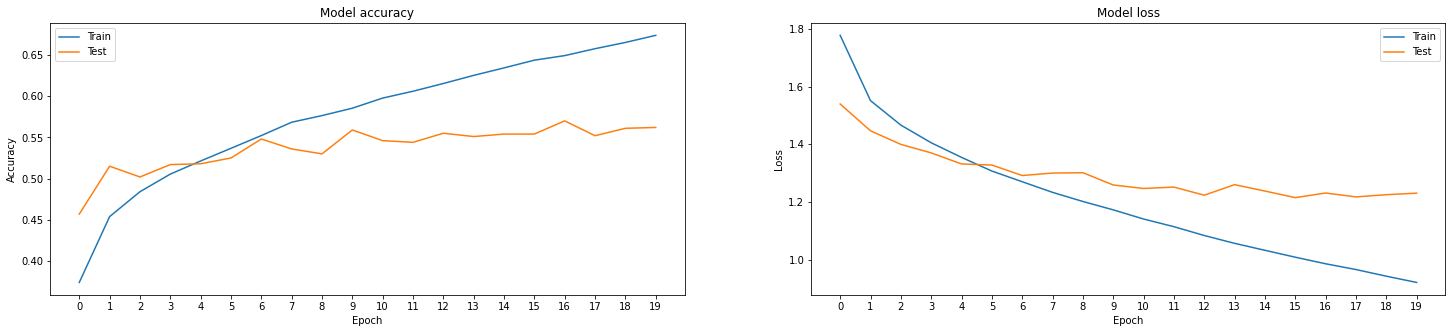

In [9]:
plotter(history)

**Accuracy of feed forward neural network is above 55%**

After experimenting with smaller number of neurons. The accuracy seemed to get stuck at around 48%. Adding more layers highly increased the training accuracy but lowered down the test accuracy and training time. Dropout was added and number of layers was brought down to 2 with high number of neurons with a suitable Dropout, which seemed to go upto and beyond 55% test accuracy. Optimizer also changed to 'adagrad' but didn't work. Learned how to create and train an Artificial Neural Network with required accuracy. I also realized that feedforward neural networks aren't suitable enough for images.

**Also note that I have divided the data into test, validation, and train for this part**

---



#Task 5-b - CNN


In [24]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#preprocessing
means = x_train.mean(axis = 0)
stddev = x_train.std(axis = 0)
x_train = (x_train-means)/stddev

means = x_test.mean(axis = 0)
stddev = x_test.std(axis = 0)
x_test = (x_test-means)/stddev

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout

#Define a model consisting mostly of convolutional and pooling layers. 
in1 = Input(shape = x_train[0].shape)
c = Conv2D(32, (3, 3), activation = 'relu', padding = 'valid')(in1)
c1 = Conv2D(32, (3, 3), activation = 'relu')(c)
m1 = MaxPooling2D()(c1)
dr1 = Dropout(0.5)(m1)
c2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'valid')(dr1)
c3 = Conv2D(64, (3, 3), activation = 'relu')(c2)
m2 = MaxPooling2D()(c3)
dr2 = Dropout(0.5)(m2)
fl = Flatten()(dr2)
d1 = Dense(1024, activation = 'relu')(fl)
dr3 = Dropout(0.5)(d1)
o = Dense(len(y_train[0]), activation = 'softmax')(dr3)

#Create Model
model = Model(inputs = in1, outputs = o)
#print(model.summary())

#Compile model and test on training data.
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])
record = model.fit(x_train, y_train, epochs = 70, batch_size = 32, validation_data=(x_test, y_test))


Epoch 1/70
1563/1563 [==============================] - 8s 5ms/step - loss: 2.1501 - acc: 0.1881 - val_loss: 1.6961 - val_acc: 0.3706
Epoch 2/70
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6869 - acc: 0.3711 - val_loss: 1.4593 - val_acc: 0.4648
Epoch 3/70
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5074 - acc: 0.4377 - val_loss: 1.4979 - val_acc: 0.4566
Epoch 4/70
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4127 - acc: 0.4815 - val_loss: 1.2411 - val_acc: 0.5535
Epoch 5/70
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3473 - acc: 0.5090 - val_loss: 1.2925 - val_acc: 0.5277
Epoch 6/70
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2923 - acc: 0.5334 - val_loss: 1.2218 - val_acc: 0.5611
Epoch 7/70
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2458 - acc: 0.5510 - val_loss: 1.0894 - val_acc: 0.6121
Epoch 8/70
1563/1563 [==============================] - 8s 5ms

In [25]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.5846 - acc: 0.8032


[0.5846114158630371, 0.8032000064849854]

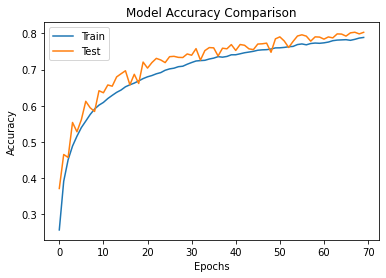

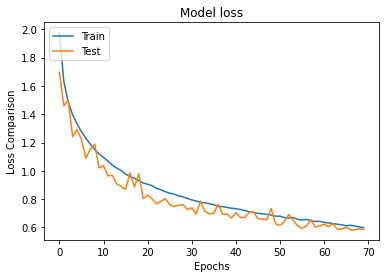

In [26]:
# Plot training & validation accuracy values
plt.plot(record.history['acc'])
plt.plot(record.history['val_acc'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.figure()
# Plot training & validation loss values
plt.plot(record.history['loss'])
plt.plot(record.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss Comparison')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**The model gives accuracy above 80 percent**

Parameters of the layers and number of layers themselves were obtained through trial and error. Program was run to 100 epochs for each 
configuration to determine optimal set up. 

The final model is given above.

Increasing the dropout layers, the dropout probability, and the dense neurons in each layer helped to generalize the model.

#Task 5-c - Transfer Learning

In [35]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.layers import BatchNormalization
import cv2
import numpy as np
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#preprocessing
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#model cut off just before the flatten layer. Used for feature extraction only
model = VGG16(include_top=False, input_shape=(32, 32, 3))
#print(model.summary())

#Train only the layers after the VGG16 feature extraction layers. 
for layer in model.layers:
    layer.trainable=False

#Add new layers on top of vgg16 - adding feed forward neural network
f1 = Flatten()(model.layers[-1].output)
dr1 = Dropout(0.25)(f1)
c1 = Dense(2048,  activation='relu')(dr1)
dr2 = Dropout(0.25)(c1)
c2 = Dense(4096, activation='relu')(dr2)
dr3 = Dropout(0.24)(c2)
c3 = Dense(2048, activation='relu')(dr3)
dr4 = Dropout(0.25)(c3)
output = Dense(10, activation='softmax')(dr4)

#final model using transfer learning
model_1 = Model(inputs=model.inputs, outputs=output)

#print(model_1.summary())

#Train and Test model
model_1.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])
record = model_1.fit(x_train, y_train, epochs = 35, batch_size = 64, validation_data=(x_test, y_test))

Epoch 1/35
782/782 [==============================] - 14s 17ms/step - loss: 2.9285 - acc: 0.4289 - val_loss: 1.1638 - val_acc: 0.6018
Epoch 2/35
782/782 [==============================] - 13s 17ms/step - loss: 1.2633 - acc: 0.5619 - val_loss: 1.0712 - val_acc: 0.6344
Epoch 3/35
782/782 [==============================] - 13s 17ms/step - loss: 1.1823 - acc: 0.5842 - val_loss: 1.0474 - val_acc: 0.6398
Epoch 4/35
782/782 [==============================] - 13s 17ms/step - loss: 1.1396 - acc: 0.5999 - val_loss: 1.0195 - val_acc: 0.6537
Epoch 5/35
782/782 [==============================] - 13s 17ms/step - loss: 1.1071 - acc: 0.6089 - val_loss: 0.9847 - val_acc: 0.6640
Epoch 6/35
782/782 [==============================] - 13s 17ms/step - loss: 1.0849 - acc: 0.6161 - val_loss: 1.0007 - val_acc: 0.6564
Epoch 7/35
782/782 [==============================] - 13s 17ms/step - loss: 1.0629 - acc: 0.6285 - val_loss: 0.9787 - val_acc: 0.6679
Epoch 8/35
782/782 [==============================] - 13s 17ms

In [38]:
model_1.evaluate(x_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.8787 - acc: 0.6987


[0.8787197470664978, 0.6987000107765198]

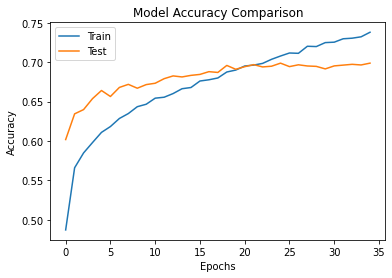

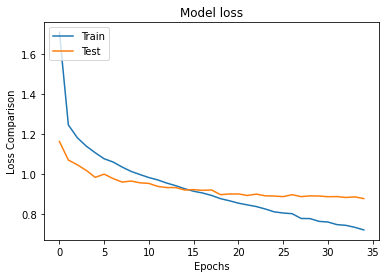

In [39]:
# Plot training & validation accuracy values
plt.plot(record.history['acc'])
plt.plot(record.history['val_acc'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.figure()
# Plot training & validation loss values
plt.plot(record.history['loss'])
plt.plot(record.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss Comparison')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



Parameters of the layers and number of layers themselves were obtained through trial and error.

Program was run to 4 epochs for each configuration to determine optimal set up. 

Higher batch size lead to lower asymptotic test accuracy. Starting with a large batch size doesn't “get the model stuck” in some neighbourhood of bad local optimums.

**After some more trial and error, I obtained test accuracy between 69-70 percent. Increasing the epochs, made the model overfitted with still the same test accuracy and higher train accuracy.**

Preprocessing function is called on the entire data set together. 

Accuracy increased as I decreased the dropout probability and increased the number of dense units, but so did overfitting, so had to maintain a balance between both.

As number of neurons in the dense layer increased and the probability of dropout decreased, I needed much less epochs to get the required test accuracy.